# <center> **M3.2 ELT and Spark SQL**</center>

### <p style="color:purple;"> Submission by Team Supreme : Raghuveer Karrotu , Vinaya Rajaram Nayak, Arivarasan Ramasamy, Gayathri Shanmuga Sundaram 
 
### <p style="color:purple;"> Assignment Description : 
### <p style="color:purple;">Load the data into a spark dataframe , Show the schema, and make any necessary changes to the data schema, Conduct any transformations, Store the data into a persistent table and Create a temp view of the data

# <center> <p style="color:green;"> **Holiday Package Analysis**</p>  </center>  
#### <p style="color:cyan;">Aim: To predict which customer is more likely to purchase the newly introduced travel package so that company could make its marketing expenditure more efficient.  </p> 

#### <p style="color:cyan;">Dataset Description : The dataset we use in this analysis is from Kaggle which was obtained from “Travel.com” website. Our dataset includes various customer demographics and company features like the following 
##### CustomerID : Unique customer Id
##### ProdTaken : This our target variable which says whether the customer purchased the product pitched.
##### Age : Age of the customer 
##### TypeofContact : How customer was contacted (Company Invited or Self Inquiry) 
##### CityTier : City tier depends on the development of a city, population, facilities, and living standards. 
##### DurationOfPitch : Duration of the pitch by a salesperson to the customer,
##### Occupation : Occupation of the customer
##### Gender : Gender of the customer
##### NumberOfPersonVisiting : Total number of persons planning to take the trip with the customer
##### NumberOfFollowups : Total number of follow-ups has been done by the salesperson after the sales pitch
##### ProductPitched : Product pitched by the salesperson
##### PreferredPropertyStar : Preferred hotel property rating by customer
##### MaritalStatus : Marital status of customer
##### NumberOfTrips : Average number of trips in a year by customer
##### Passport : The customer has a passport or not (0: No, 1: Yes)
##### PitchSatisfactionScore : Sales pitch satisfaction score
##### OwnCar : Whether the customers own a car or not (0: No, 1: Yes)
##### NumberOfChildrenVisiting : Total number of children with age less than 5 planning to take the trip with the customer
##### Designation : Designation of the customer in the current organization
##### MonthlyIncome : Gross monthly income of the customer
</p> 


In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession;

spark = SparkSession.builder.master("local[4]").appName("ISM6562 Spark Assignment App").getOrCreate();

# Let's get the SparkContext object. It's the entry point to the Spark API. It's created when you create a sparksession
sc = spark.sparkContext  

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/16 17:55:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [2]:
# this will set the log level to ERROR. This will hide the INFO or WARNING messages that are printed out by default. If you want to see them, set this to INFO or WARN.
sc.setLogLevel("ERROR") 

In [3]:
spark

## Loading our data into spark dataframe. 

In [4]:
# Load CSV file
df_spark = spark.read.csv("Travel.csv", header=True, inferSchema=True)
df_spark.show()

+----------+---------+----+---------------+--------+---------------+--------------+------+----------------------+-----------------+--------------+---------------------+-------------+-------------+--------+----------------------+------+------------------------+--------------+-------------+
|CustomerID|ProdTaken| Age|  TypeofContact|CityTier|DurationOfPitch|    Occupation|Gender|NumberOfPersonVisiting|NumberOfFollowups|ProductPitched|PreferredPropertyStar|MaritalStatus|NumberOfTrips|Passport|PitchSatisfactionScore|OwnCar|NumberOfChildrenVisiting|   Designation|MonthlyIncome|
+----------+---------+----+---------------+--------+---------------+--------------+------+----------------------+-----------------+--------------+---------------------+-------------+-------------+--------+----------------------+------+------------------------+--------------+-------------+
|    200000|        1|  41|   Self Enquiry|       3|              6|      Salaried|Female|                     3|                3

# Data Exploration and transformations 

In [5]:
df_spark.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- ProdTaken: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- TypeofContact: string (nullable = true)
 |-- CityTier: integer (nullable = true)
 |-- DurationOfPitch: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- NumberOfPersonVisiting: integer (nullable = true)
 |-- NumberOfFollowups: integer (nullable = true)
 |-- ProductPitched: string (nullable = true)
 |-- PreferredPropertyStar: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- NumberOfTrips: integer (nullable = true)
 |-- Passport: integer (nullable = true)
 |-- PitchSatisfactionScore: integer (nullable = true)
 |-- OwnCar: integer (nullable = true)
 |-- NumberOfChildrenVisiting: integer (nullable = true)
 |-- Designation: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)



# Visualizing data

<Axes: xlabel='DurationOfPitch', ylabel='count'>

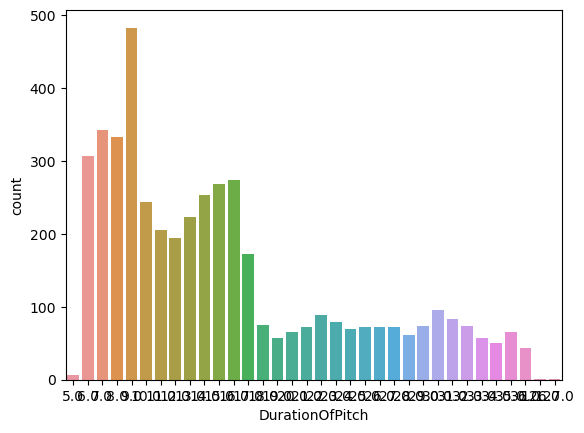

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_spark is the Spark DataFrame containing the column of interest
# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df_spark.toPandas()

sns.countplot(x='DurationOfPitch', data=df_pandas) # checking distribution of "durationofpitch"

# Finding missing values

In [7]:
from pyspark.sql.functions import col

# Find columns with missing values
columns_with_missing_values = [column for column in df_spark.columns if df_spark.filter(col(column).isNull()).count() > 0]

# Print columns with missing values
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)


Columns with missing values:
Age
TypeofContact
DurationOfPitch
NumberOfFollowups
PreferredPropertyStar
NumberOfTrips
NumberOfChildrenVisiting
MonthlyIncome


# Imputing missing values

In [8]:
from pyspark.sql.functions import col

# Group by the column and apply the count() function
count_df = df_spark.groupBy("TypeofContact").count()

# Show the resulting counts
count_df.show()

+---------------+-----+
|  TypeofContact|count|
+---------------+-----+
|           null|   25|
|   Self Enquiry| 3444|
|Company Invited| 1419|
+---------------+-----+



Since, TypeofContact column is in string object, imputing with the most frequent value

In [9]:
df_spark = df_spark.fillna("Self Enquiry", subset=["TypeofContact"])

Imputing with missing value with median value for numeric values

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.functions import percentile_approx
from pyspark.sql.functions import when

# Iterate over columns with missing values
for column in columns_with_missing_values:
    # Calculate median of the column
    median_value = df_spark.select(column).agg(percentile_approx(column, 0.5)).collect()[0][0]
    if median_value is not None:
    # Round median_value to nearest integer
        median_value_rounded = int(round(median_value))
    else:
        median_value_rounded = 0
    
    # Impute missing values with median value
    df_spark = df_spark.withColumn(column, when(col(column).isNull(), median_value_rounded).otherwise(col(column)))


In [11]:
# verifying if all missing values were imputed
columns_with_missing_values = [column for column in df_spark.columns if df_spark.filter(col(column).isNull()).count() > 0]

# Print columns with missing values
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)

Columns with missing values:


In [12]:
# Export DataFrame to CSV
df_spark.write.csv("processedfile.csv")

In [13]:
df_spark.show(20)

+----------+---------+---+---------------+--------+---------------+--------------+------+----------------------+-----------------+--------------+---------------------+-------------+-------------+--------+----------------------+------+------------------------+--------------+-------------+
|CustomerID|ProdTaken|Age|  TypeofContact|CityTier|DurationOfPitch|    Occupation|Gender|NumberOfPersonVisiting|NumberOfFollowups|ProductPitched|PreferredPropertyStar|MaritalStatus|NumberOfTrips|Passport|PitchSatisfactionScore|OwnCar|NumberOfChildrenVisiting|   Designation|MonthlyIncome|
+----------+---------+---+---------------+--------+---------------+--------------+------+----------------------+-----------------+--------------+---------------------+-------------+-------------+--------+----------------------+------+------------------------+--------------+-------------+
|    200000|        1| 41|   Self Enquiry|       3|              6|      Salaried|Female|                     3|                3|   

# Store the data into a persistent table and create a temp view of the data


In [14]:
# Create a database
spark.sql("CREATE DATABASE IF NOT EXISTS Travel")

# Use the database
spark.sql("USE Travel")



DataFrame[]

In [15]:
# Store the data into a persistent table in the Travel db
df_spark.write.saveAsTable("travel_information")


In [16]:
# Create a temporary view of the data
df_spark.createOrReplaceTempView("travel_information_view")

In [17]:
# Verify if the table exists in the created database
check = spark.sql("SHOW TABLES")
if check.filter(check.tableName == "travel_information_view").count() > 0:
    print("Table exists in the created database.")

Table exists in the created database.


# Now let us find some insights by using the aggregation.
#### <p style="color:orange;"> 1. The average age of customers </p>
<p style="color:orange;">First we are interested to know the average age of customers </p>


In [18]:
avg_age_result = spark.sql("SELECT AVG(Age) as avg_age FROM travel_information_view").show()

+-----------------+
|          avg_age|
+-----------------+
|37.54725859247136|
+-----------------+



#### <p style="color:orange;"> 2. Occupation wise display </p>
<p style="color:orange;">Next let us calculate  the number of customers who have taken a product in  each occupation. We calculate the total number of customers and no of customers who bought the product in each occupation.</p>


In [19]:
total_result = spark.sql("""
    SELECT Occupation, COUNT(*) AS total_customers, SUM(ProdTaken) AS customers_taken_product
    FROM travel_information_view
    GROUP BY Occupation
""").show()

+--------------+---------------+-----------------------+
|    Occupation|total_customers|customers_taken_product|
+--------------+---------------+-----------------------+
|      Salaried|           2368|                    414|
|Large Business|            434|                    120|
|   Free Lancer|              2|                      2|
|Small Business|           2084|                    384|
+--------------+---------------+-----------------------+



#### <p style="color:orange;"> 3. Occupation wise average age and monthly income  </p>
<p style="color:orange;">Now let us calculate the average age and monthly income for each occupation. We have grouped the avg age and monthlyincome by occupation for the below results </p> 


In [20]:
ocupation_results = spark.sql("""WITH cte AS (
    SELECT Occupation, AVG(Age) AS avg_age, AVG(`MonthlyIncome`) AS avg_monthly_income
    FROM travel_information_view
    GROUP BY Occupation
)
SELECT Occupation, avg_age, avg_monthly_income
FROM cte""").show()

+--------------+------------------+------------------+
|    Occupation|           avg_age|avg_monthly_income|
+--------------+------------------+------------------+
|      Salaried|37.569679054054056| 23591.93918918919|
|Large Business| 36.60829493087557|22859.873271889403|
|   Free Lancer|              37.5|           18929.0|
|Small Business| 37.71737044145873|23672.031669865642|
+--------------+------------------+------------------+



#### <p style="color:orange;"> 4. Percentage of customers who bought the package pitched. </p>
<p style="color:orange;">Finally let us calculate the the percentage of customers who have taken a product based on the product pitched. For this we selected the product pitched, count of customers and sum of the prodtaken and then grouped by product pitched to get the necessary results </p>  


In [21]:
purchased_percent_result = spark.sql("""
    SELECT ProductPitched, COUNT(*) AS total_customers, SUM(ProdTaken) AS customers_taken_product,
           (SUM(ProdTaken) / COUNT(*) * 100) AS percentage_taken_product
    FROM travel_information_view
    GROUP BY ProductPitched
    ORDER BY percentage_taken_product DESC
""").show()

+--------------+---------------+-----------------------+------------------------+
|ProductPitched|total_customers|customers_taken_product|percentage_taken_product|
+--------------+---------------+-----------------------+------------------------+
|         Basic|           1842|                    552|      29.967426710097723|
|      Standard|            742|                    124|      16.711590296495956|
|        Deluxe|           1732|                    204|      11.778290993071593|
|          King|            230|                     20|       8.695652173913043|
|  Super Deluxe|            342|                     20|       5.847953216374268|
+--------------+---------------+-----------------------+------------------------+

